#Carregar Libs

- Preprocessing: data load/augmentation, transformação de dados
- Otimizadores
- Layers e Models: componentes da rede e funções de composição e produção de variáveis (input).
- Backends 
- Callbacks: salvar modelo em meio a execução(checkpoint), agendar mudança de parametros e visualizar grafo de computação

In [1]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import optimizers
from keras.models import Sequential, Model, Input
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Conv2D, MaxPooling2D
from keras import backend as K 
import tensorflow as TF
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard as Board, EarlyStopping
import numpy as np
#K.clear_session()

# For Tensorboard Visualization
from IPython.display import clear_output, Image, display, HTML

Using TensorFlow backend.


In [0]:
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1.axes_rgb import RGBAxes

#Data Load/Augmentation

- flow_from_dir without any arg and ``` classes = [" "] ``` will load the entire image dataset.

In [0]:
data_gen = ImageDataGenerator()

In [22]:
dataload_dir = data_gen.flow_from_directory('/content/',target_size=(224,224), classes = [''], batch_size= 1)

Found 1 images belonging to 1 classes.


In [0]:
batch0 = dataload_dir.next()

In [0]:
dataload_dir

'float32'

In [0]:
np.shape(batch0[0])

(1, 550, 550, 3)

##**Display Image-Data-Set**
- The first of the ndarray (tensor) batch holds for the dataset sample.
- We are using RGB function from Matplotlib, to use this you must use the three channels of the batch tensor, the last index, they hold for RGB. They must be int.


(<matplotlib.image.AxesImage at 0x7fa046866cf8>,
 <matplotlib.image.AxesImage at 0x7fa04677c390>)

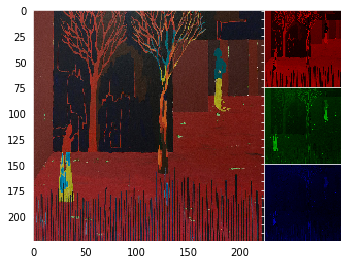

In [24]:
batch = batch0[0]
fig = plt.figure()
ax = RGBAxes(fig,[0.1,0.1,0.8,0.8])
ax.imshow_rgb(np.int32(batch[0,:,:,0]),np.int32(batch[0,:,:,1]),np.int32(batch[0,:,:,2]),interpolation='none')

#Transfer-Learning
- Load Model VGG19 trained in ImageNet dataset.

##Extract Network Layers
 1.   Build New Model in what will be transfered network layers.
 2.   Replace the model layers built with the pre-trained loaded model in the first step.
 
##Train New Model
 1. Stack New Layers upon the transfered model and train it from scratch.








**Load Model**

>We will be using Keras direct support to trained VGG19, however you can load any pre-trained model compressed in a h5py file. Be sure to initiallize the optmizator (through the .compile function) SGD or whatever it may be.

In [0]:
from tensorflow.compat.v1.graph_util import convert_variables_to_constants

def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    """
    Freezes the state of a session into a pruned computation graph.

    Creates a new computation graph where variable nodes are replaced by
    constants taking their current value in the session. The new graph will be
    pruned so subgraphs that are not necessary to compute the requested
    outputs are removed.
    @param session The TensorFlow session to be frozen.
    @param keep_var_names A list of variable names that should not be frozen,
                          or None to freeze all the variables in the graph.
    @param output_names Names of the relevant graph outputs.
    @param clear_devices Remove the device directives from the graph for better portability.
    @return The frozen graph definition.
    """    
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in TF.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in TF.global_variables()]
        # Graph -> GraphDef ProtoBuf
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        frozen_graph = convert_variables_to_constants(session, input_graph_def,
                                                      output_names, freeze_var_names)
        return frozen_graph

In [0]:
#Importing pre-trained models
from keras import applications

In [0]:
# Save model in .pb.modelzoo to load model as graph and to visualize it with Lucid

K.set_session(TF.Session())
model = applications.VGG19(weights = "imagenet", include_top=False, input_shape = (224, 224, 3))    
with K.get_session() as sess:  
    frozen_graph = freeze_session(sess, output_names=[out.op.name for out in model.outputs])
    TF.train.write_graph(frozen_graph, "model", "./Model.pb.modelzoo", as_text=False)    
TF.reset_default_graph()

In [0]:
#Tensorboard viz

In [0]:
model_fn = '/content/model/Model.pb.modelzoo'
#model_fn = '/content/tensorflow_inception_graph.pb'

# creating TensorFlow session and loading the model
graph = TF.Graph()
sess = TF.InteractiveSession(graph=graph)
with TF.gfile.GFile(model_fn, 'rb') as f:
    graph_def = TF.GraphDef()
    graph_def.ParseFromString(f.read())
t_input = TF.placeholder(np.float32, name='input_1') # define the input tensor
imagenet_mean = 117.0
t_preprocessed = TF.expand_dims(t_input-imagenet_mean, 0)
TF.import_graph_def(graph_def, {'input_1':t_preprocessed} )

In [0]:
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = TF.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = TF.compat.as_bytes("<stripped %d bytes>"%size)
    return strip_def
  
def rename_nodes(graph_def, rename_func):
    res_def = TF.GraphDef()
    for n0 in graph_def.node:
        n = res_def.node.add() 
        n.MergeFrom(n0)
        n.name = rename_func(n.name)
        for i, s in enumerate(n.input):
            n.input[i] = rename_func(s) if s[0]!='^' else '^'+rename_func(s[1:])
    return res_def

In [0]:
def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))
  
    iframe = """
        <iframe seamless style="width:800px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [37]:
show_graph(graph_def)

##Visualization of a Feature Channel of Hidden Layer
  - Using Lucid to do ease to build feature visualizations

In [6]:
# Install Lucid

!pip install --quiet lucid==0.2.3
#!pip install --quiet --upgrade-strategy=only-if-needed git+https://github.com/tensorflow/lucid.git

     |████████████████████████████████| 40kB 5.3MB/s 


In [0]:
# Imports

import lucid.modelzoo.vision_models as models
from lucid.modelzoo.vision_base import Model
from lucid.misc.io import show
import lucid.optvis.objectives as objectives
import lucid.optvis.param as param
import lucid.optvis.render as render
import lucid.optvis.transform as transform

In [0]:
# Define model with input placeholder information. Use Model inheritance to do so, using load_graphdef() function, to use Model.pb.modelzoo graphdef

class VGG(Model):
  model_path = '/content/model/Model.pb.modelzoo'
  image_shape = [224, 224, 3]
  image_value_range = (0, 1)
  image
  input_name = 'input_1'

In [0]:
# Load Model

model = VGG()
model.load_graphdef()

512 0.03753511



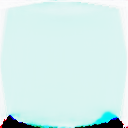

512 0.6340648



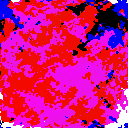

512 2.7808402



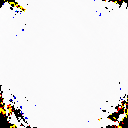

512 0.037695404



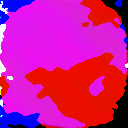

In [42]:
_ = render.render_vis(model, "block1_conv1/convolution:10")
_ = render.render_vis(model, "block1_conv1/convolution:23")
_ = render.render_vis(model, "block1_conv1/convolution:31")
_ = render.render_vis(model, "block1_conv1/convolution:51")

512 14.048397



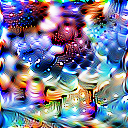

In [38]:
channel = lambda n: objectives.channel("block5_conv4/convolution", n)
obj = channel(511) + channel(411) + channel(311) + channel(211)
_ = render.render_vis(model, obj)

512 46.629715



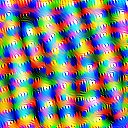

In [43]:
channel = lambda n: objectives.channel("block5_conv4/convolution", n)
otherlayerchannel = lambda n: objectives.channel("block3_conv3/convolution", n)
obj = channel(511) + channel(411) + otherlayerchannel(111) + otherlayerchannel(211)
_ = render.render_vis(model, obj)

In [0]:
#param_f = lambda: param.image(128, fft=True, decorrelate=True)
#param_f = lambda: param.image(batch[0])
#_ = render.render_vis(model, obj, param_f)

In [0]:
# Let's import a model from the Lucid modelzoo!

#model = models.InceptionV1()
#model = applications.VGG19(weights = "imagenet", include_top=False, input_shape = (224, 224, 3))    
#model.load_graphdef()

In [0]:
from __future__ import print_function
import os
from io import BytesIO
import numpy as np
from functools import partial
import PIL.Image
# Picking some internal layer. Note that we use outputs before applying the ReLU nonlinearity
# to have non-zero gradients for features with negative initial activations.
layer = 'block5_conv3'
#layer = 'mixed4d_3x3_bottleneck_pre_relu'

# start with a gray image with a little noise
img_noise = np.random.uniform(size=(225,225,3)) + 100.0
#img_noise = batch[0,:,:,:]

def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 1)*255)
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))
    
def visstd(a, s=0.1):
    '''Normalize the image range for visualization'''
    return (a-a.mean())/max(a.std(), 1e-4)*s + 0.5

def T(layer):
    '''Helper for getting layer output tensor'''
    return graph.get_tensor_by_name("import/%s/convolution:0"%layer)

def render_naive(t_obj, img0=img_noise, iter_n=2400, step=.1):
    t_score = TF.reduce_mean(t_obj) # defining the optimization objective    
    t_grad = TF.gradients(t_score, t_input)[0] # behold the power of automatic differentiation!
    
    img = img0.copy()    
    for i in range(iter_n):
        g, score = sess.run([t_grad, t_score], {t_input:img})    
        # normalizing the gradient, so the same step size should work 
        g /= g.std()+1e-8         # for different layers and networks
        img += g*step
        print(score, end = ' ')        
    clear_output()
    showarray(visstd(img))

channel = np.random.randint(0,40,8)
np.sort(np.unique(channel))
#render_naive(T(layer))
#render_naive(T(layer)[:,:,:,channel[1]:channel[0]])
render_naive(T(layer)[:,10,10,channel[0]])
#render_naive(T(layer)[:,:,:,channel[1]])
#render_naive(T(layer)[:,:,:,channel[2]])


In [0]:
t_score = TF.reduce_mean(graph.get_tensor_by_name("import/%s:0"%layer)) # defining the optimization objective
t_grad = TF.gradients(t_score, t_input) # behold the power of automatic differentiation!
print(t_grad)

[<tf.Tensor 'gradients_3/sub_grad/Reshape:0' shape=<unknown> dtype=float32>]


In [0]:
op = graph.get_operation_by_name('import/import/block3_conv2/BiasAdd')
op.outputs

[<tf.Tensor 'import/import/block3_conv2/BiasAdd:0' shape=(?, 512, 512, 256) dtype=float32>]

In [0]:
sess.close()
TF.reset_default_graph()

##Extract Network Layers

###1. Build New Model
 >For this we will be using usual Keras interface for 2D Convolutional Nets with Max Pooling. This Network will be receiving the first layers of VGG19 ImageNet Pre-Trained Network.


In [0]:
img_width, img_height = 2050, 2050

### Build the network 
# Block 1
img_input = Input(shape=(img_width, img_height, 3))
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

# Block 2
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

newmodel = Model(input = img_input, output = x)

newmodel.summary()

In [0]:
# Dictionary using tuples layer name-weights
layer_dict = dict([(layer.name, layer) for layer in newmodel.layers])
layer_names = [layer.name for layer in newmodel.layers]

###2. Replace the Model-Layers
>

In [0]:
for i in layer_dict.keys():    
    index = layer_names.index(i)    
    for j in model.layers:       
        if i == j.name:           
            w = model.layers[model.layers.index(j)]
            newmodel.layers[index].set_weights(w.get_weights())            

In [0]:
with tf.variable_scope('foo', reuse=tf.AUTO_REUSE):
    tinput = tf.get_variable('tensor_input1', initializer= batch)

In [0]:
with tf.variable_scope('foo', reuse=tf.AUTO_REUSE):
    modeloleitura = newmodel.call(tinput)

In [0]:
modeloleitura.get_shape()

TensorShape([Dimension(6), Dimension(512), Dimension(512), Dimension(128)])

In [0]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

In [0]:
with tf.variable_scope('foo', reuse=tf.AUTO_REUSE):
    nptensor = modeloleitura.eval(session=sess)
  


In [0]:
sess.close()

##Train New Model

###1. Stack New Layers 
> Add new layers with Keras Interface to train your model.


In [0]:
img = load_img('anny0.jpg')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

In [0]:
# Data Augmentation
datagen = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = True,
fill_mode = "nearest",
zoom_range = 0.3,
width_shift_range = 0.3,
height_shift_range=0.3,
rotation_range=30)

In [0]:
# Generates Batch of Data
i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='./', save_prefix='anny', save_format='jpeg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely

In [0]:
img = load_img('/content/anny_0_1461.jpeg')  # this is a PIL image
x0 = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x0 = x0.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

In [0]:
img_width, img_height = 1543, 1062

### Build the network 
img_input = Input(shape=(1543, 1062, 3))
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

# Block 2
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

model = Model(input = img_input, output = x)

model.summary()
"""
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0         
=================================================================
Total params: 260,160.0
Trainable params: 260,160.0
Non-trainable params: 0.0
"""

layer_dict = dict([(layer.name, layer) for layer in model.layers])
[layer.name for layer in model.layers]
"""
['input_1',
 'block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool']
"""


NameError: ignored

In [0]:

import h5py
weights_path = 'vgg19_weights.h5' # ('https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg19_weights_tf_dim_ordering_tf_kernels.h5)
f = h5py.File(weights_path)

list(f["model_weights"].keys())
"""
['block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block3_conv4',
 'block3_pool',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block4_conv4',
 'block4_pool',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3',
 'block5_conv4',
 'block5_pool',
 'dense_1',
 'dense_2',
 'dense_3',
 'dropout_1',
 'global_average_pooling2d_1',
 'input_1']
"""

# list all the layer names which are in the model.
layer_names = [layer.name for layer in model.layers]


"""
# Here we are extracting model_weights for each and every layer from the .h5 file
>>> f["model_weights"]["block1_conv1"].attrs["weight_names"]
array([b'block1_conv1/kernel:0', b'block1_conv1/bias:0'], 
      dtype='|S21')
# we are assiging this array to weight_names below 
>>> f["model_weights"]["block1_conv1"]["block1_conv1/kernel:0]
<HDF5 dataset "kernel:0": shape (3, 3, 3, 64), type "<f4">
# The list comprehension (weights) stores these two weights and bias of both the layers 
>>>layer_names.index("block1_conv1")
1
>>> model.layers[1].set_weights(weights)
# This will set the weights for that particular layer.
With a for loop we can set_weights for the entire network.
"""
for i in layer_dict.keys():
    weight_names = f["model_weights"][i].attrs["weight_names"]
    weights = [f["model_weights"][i][j] for j in weight_names]
    index = layer_names.index(i)
    model.layers[index].set_weights(weights)

    
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import itertools
import glob

features = []
for i in tqdm(files_location):
        im = cv2.imread(i)
        im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (256, 256)).astype(np.float32) / 255.0
        im = np.expand_dims(im, axis =0)
        outcome = model_final.predict(im)
        features.append(outcome)
        
## collect these features and create a dataframe and train a classfier on top of it.